In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set_theme(style="darkgrid")

In [97]:
# Loading ratings 
names = ["User ID", "Movie ID", "Rating"]
ratings_df = pd.read_csv("Data/ml-100k/u.data", sep="\t", usecols=[0,1,2], names=names)

                                          Title
0                              Toy Story (1995)
1                              GoldenEye (1995)
2                             Four Rooms (1995)
3                             Get Shorty (1995)
4                                Copycat (1995)
...                                         ...
1677                          Mat' i syn (1997)
1678                           B. Monkey (1998)
1679                       Sliding Doors (1998)
1680                        You So Crazy (1994)
1681  Scream of Stone (Schrei aus Stein) (1991)

[1682 rows x 1 columns]


In [37]:
ratings_df.head()

,User ID,Movie ID,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [12]:
n_ratings = ratings_df.shape[0]
n_users = len(ratings_df["user_id"].unique())
n_items = len(ratings_df["item_id"].unique())

print("Total number of ratings in the dataset: %i" % (n_ratings))
print("Number of persons who rated movies: %i" % (n_users))
print("Number of rated movies: %i" % (n_items))

Total number of ratings in the dataset: 100000
Number of persons who rated movies: 943
Number of rated movies: 1682


In [14]:
summary = ratings_df["rating"].describe()
summary

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

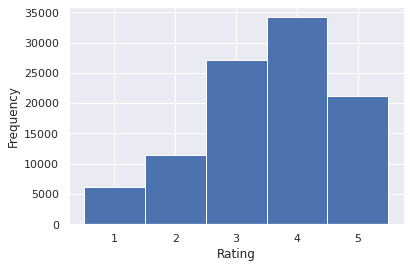

In [35]:
plt.hist(ratings_df["rating"], bins=range(1, 7), align="left")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)

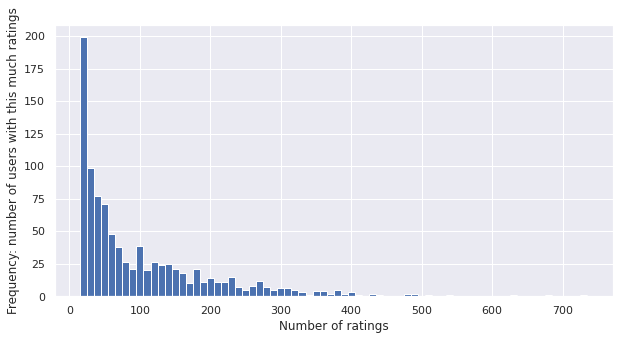

In [85]:
users_list = range(1, n_users + 1)
n_ratings = [np.count_nonzero(ratings_df["User ID"] == i) for i in users_list]
n_ratings = np.array(n_ratings)

binwidth = 10
bins = np.arange(min(n_ratings), max(n_ratings)+binwidth, binwidth)
plt.figure(figsize=(10,5))
plt.hist(n_ratings, bins=bins, align="left")
plt.xlabel("Number of ratings")
plt.ylabel("Frequency: number of users with this much ratings")
plt.show()

In [62]:
n_ratings_df = pd.DataFrame(n_ratings)
summary = n_ratings_df.describe()

summary

,0
count,943.000000
mean,106.044539
std,100.931743
min,20.000000
25%,33.000000
50%,65.000000
75%,148.000000
max,737.000000


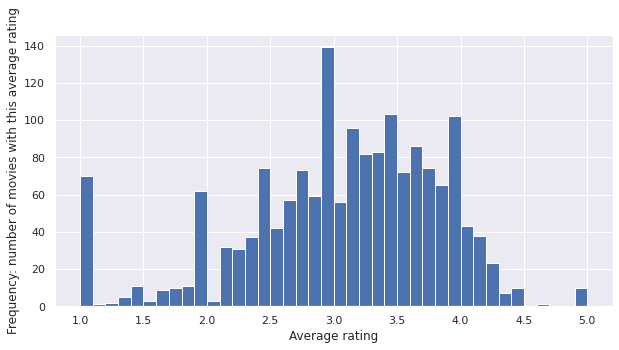

In [94]:
movies_list = range(1, n_items + 1)
mean_ratings = [ratings_df["Rating"][ratings_df["Movie ID"] == i].mean() for i in movies_list]
mean_ratings = np.array(mean_ratings)

binwidth = 0.1
bins = np.arange(min(mean_ratings), max(mean_ratings)+binwidth, binwidth)
plt.figure(figsize=(10,5))
plt.hist(mean_ratings, bins=bins, align="mid")
plt.xlabel("Average rating")
plt.ylabel("Frequency: number of movies with this average rating")
plt.show()

In [112]:
# Loading movies titles
movie_titles = pd.read_csv("Data/ml-100k/u.item", sep="|", header=None, usecols=[1], 
                           encoding='iso-8859-1', names=["Title"])

bad_movies, good_movies = [], []
for i in range(len(mean_ratings)):
    if mean_ratings[i] == 1:
        bad_movies.append(movie_titles["Title"][i])
    if mean_ratings[i] == 5:
        good_movies.append(movie_titles["Title"][i])

print("Example of movie with rating of 1:", np.random.choice(bad_movies))
print("Example of movie with rating of 5:", np.random.choice(good_movies))

Example of movie with rating of 1: Falling in Love Again (1980)
Example of movie with rating of 5: Saint of Fort Washington, The (1993)


In [121]:
from scipy import sparse

users = ratings_df["User ID"].values
movies = ratings_df["Movie ID"].values
rating = ratings_df["Rating"].values

matrix_sparse = sparse.csr_matrix((rating, (users, movies)), shape=(n_users+1, n_items+1))
R = matrix_sparse.todense()
R = np.array(R[1:, 1:])

print("Verify rating of user 196 for movie 242 (first row in data file): ", R[195, 241])

Verify rating of user 196 for movie 242 (first row in data file):  3


In [133]:
sparsity = len(R.nonzero()[0]) / (R.shape[0] * R.shape[1])
print("Sparsity of R: %0.2f%%" % (sparsity * 100))

Sparsity of R: 6.30%


6.30% of the user-item ratings have a value. Missing values are filled with zeros but they do not represent zero on the same scale as the ratings, they are simply empty entries. Ratings are defined from 1 to 5.

In [154]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=20, init="nndsvda", max_iter=int(1e3))
nmf.fit(R)
W = nmf.transform(R)
H = nmf.components_

print("Number of iterations: ", nmf.n_iter_)
print("Movies features shape (transpose(H)): ", H.T.shape)
print("Users features shape (W): ", W.shape)
print("Reconstruction of R shape (W.H): ", W.dot(H).shape)

Number of iterations:  682
Movies features shape (transpose(H)):  (1682, 20)
Users features shape (W):  (943, 20)
Reconstruction of R shape (W.H):  (943, 1682)


In [166]:
print(R)
R_pred = W.dot(H)
R_pred[R_pred > 5] = 5.
R_pred[R_pred < 1] = 1.

print(R_pred.astype(np.int8))

[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]]
[[4 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [2 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 2 1 ... 1 1 1]]


In [194]:
n_recommendations = 5
user_idx = 12
ratings_user = R[user_idx, :]
predictions_user = R_pred[user_idx, :]

print("Preferred movies for user %i:" % user_idx)
print("\nTitle | Rating\n-------------------------------")
favorite_movies_index = np.argsort(-ratings_user)
for i in range(n_recommendations):
    index = favorite_movies_index[i]
    print(movie_titles["Title"][index], " | ", ratings_user[index])

unseen_indices = np.where(ratings_user == 0)[0]
predictions_unseen = predictions_user[unseen_indices]
print("\n\nRecommended movies for user %i:" % user_idx)
print("\nTitle | Rating\n-------------------------------")
predicted_movies_index = np.argsort(-predictions_unseen)
for i in range(n_recommendations):
    index = unseen_indices[predicted_movies_index[i]]
    print(movie_titles["Title"][index], " | ", predictions_user[index])

Preferred movies for user 12:

Title | Rating
-------------------------------
Clear and Present Danger (1994)  |  5
Dave (1993)  |  5
Lone Star (1996)  |  5
Go Fish (1994)  |  5
Godfather, The (1972)  |  5


Recommended movies for user 12:

Title | Rating
-------------------------------
Citizen Kane (1941)  |  4.314467271617793
Vertigo (1958)  |  4.104992066923607
Unforgiven (1992)  |  3.613896567390366
It's a Wonderful Life (1946)  |  3.61196291304805
Room with a View, A (1986)  |  3.468117108047332


In [195]:
# creating a new user profile:
my_ratings = np.zeros((1682,1), dtype=int)
my_ratings[0] = 4 
my_ratings[1] = 4 
my_ratings[10] = 1 
my_ratings[15] = 3
my_ratings[27] = 4
my_ratings[34] = 1
my_ratings[49] = 1
my_ratings[55] = 1
my_ratings[61] = 1
my_ratings[68] = 5
my_ratings[70] = 4
my_ratings[81] = 4
my_ratings[87] = 2
my_ratings[94] = 4
my_ratings[120] = 2
my_ratings[171] = 1
my_ratings[173] = 4
my_ratings[175] = 1
my_ratings[182] = 1
my_ratings[194] = 2
my_ratings[203] = 5
my_ratings[209] = 5
my_ratings[221] = 1
my_ratings[234] = 2
my_ratings[312] = 3
my_ratings[317] = 3
my_ratings[322] = 3
my_ratings[342] = 1
my_ratings[378] = 1
my_ratings[379] = 1
my_ratings[392] = 3
my_ratings[404] = 2
my_ratings[422] = 4
my_ratings[542] = 4

In [198]:
newR = np.r_[R, my_ratings.T]

new_nmf = NMF(n_components=20, init="nndsvda", max_iter=int(1e3))
new_nmf.fit(R)
newW = new_nmf.transform(R)
newH = new_nmf.components_

print("Number of iterations: ", nmf.n_iter_)
print("Movies features shape (transpose(H)): ", H.T.shape)
print("Users features shape (W): ", W.shape)
print("Reconstruction of R shape (W.H): ", W.dot(H).shape)

Number of iterations:  682
Movies features shape (transpose(H)):  (1682, 20)
Users features shape (W):  (943, 20)
Reconstruction of R shape (W.H):  (943, 1682)


In [201]:
print(newR)
newR_pred = newW.dot(newH)
newR_pred[newR_pred > 5] = 5.
newR_pred[newR_pred < 1] = 1.

print(newR_pred.astype(np.int8))

[[5 3 4 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [4 4 0 ... 0 0 0]]
[[4 2 1 ... 1 1 1]
 [2 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [2 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 2 1 ... 1 1 1]]


In [202]:
n_recommendations = 5
user_idx = -1
ratings_user = newR[user_idx, :]
predictions_user = newR_pred[user_idx, :]

print("Preferred movies for user %i:" % user_idx)
print("\nTitle | Rating\n-------------------------------")
favorite_movies_index = np.argsort(-ratings_user)
for i in range(n_recommendations):
    index = favorite_movies_index[i]
    print(movie_titles["Title"][index], " | ", ratings_user[index])

unseen_indices = np.where(ratings_user == 0)[0]
predictions_unseen = predictions_user[unseen_indices]
print("\n\nRecommended movies for user %i:" % user_idx)
print("\nTitle | Rating\n-------------------------------")
predicted_movies_index = np.argsort(-predictions_unseen)
for i in range(n_recommendations):
    index = unseen_indices[predicted_movies_index[i]]
    print(movie_titles["Title"][index], " | ", predictions_user[index])

Preferred movies for user -1:

Title | Rating
-------------------------------
Forrest Gump (1994)  |  5
Back to the Future (1985)  |  5
Indiana Jones and the Last Crusade (1989)  |  5
Toy Story (1995)  |  4
GoldenEye (1995)  |  4


Recommended movies for user -1:

Title | Rating
-------------------------------
Silence of the Lambs, The (1991)  |  4.655566930119134
Shawshank Redemption, The (1994)  |  4.535205463448564
Braveheart (1995)  |  4.280688921437096
Fugitive, The (1993)  |  4.26558721593572
Terminator 2: Judgment Day (1991)  |  4.210044373568926


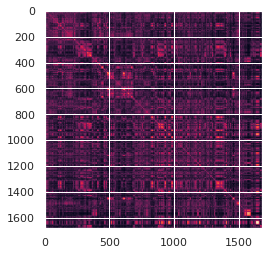

In [206]:
from sklearn.metrics.pairwise import cosine_similarity

movies_sim = cosine_similarity(H.T)
plt.imshow(movies_sim)
plt.show()

In [238]:
n_recommendations = 5

watch_index = np.random.randint(0, len(movie_titles["Title"]))
print("Currently watching: ", movie_titles["Title"][watch_index])

movies_similarities = movies_sim[watch_index, :]
suggestions = np.argsort(-movies_similarities)[1:n_recommendations + 1]

print("\n\nRecommended movies for user:")
print("\nTitle | Similarity\n-------------------------------")
for i in suggestions:
    print(movie_titles["Title"][i], " | ", movies_similarities[i])

Currently watching:  I Know What You Did Last Summer (1997)


Recommended movies for user:

Title | Similarity
-------------------------------
G.I. Jane (1997)  |  0.9740485962121023
Jackal, The (1997)  |  0.954089099168919
Hoodlum (1997)  |  0.9450149605370199
Kiss the Girls (1997)  |  0.94386058223922
Fire Down Below (1997)  |  0.9352965294906131


In [232]:
print(movies_sim)

[[1.         0.19338145 0.41904896 ... 0.         0.00104729 0.01717461]
 [0.19338145 1.         0.11330318 ... 0.         0.55859873 0.05314556]
 [0.41904896 0.11330318 1.         ... 0.         0.17764218 0.09125021]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.00104729 0.55859873 0.17764218 ... 0.         1.         0.14079699]
 [0.01717461 0.05314556 0.09125021 ... 0.         0.14079699 1.        ]]
